In [1]:
%matplotlib notebook

import os
import time
import numpy as np
import matplotlib as mpl

from collections import OrderedDict
from importlib import reload
from matplotlib import pyplot as plt

from labtools import mplplots; reload(mplplots)
from labtools.mplplots.init_nb_plotting import *
from labtools.mplplots import tools as mpltools

import qcodes as qc
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import DataSet
from qcodes.sweep import sweep, nest, chain, szip, getter, setter, time_trace
#from qcodes.sweep.sweep import ParameterSweep, Nest, ParameterWrapper, FunctionWrapper, FunctionSweep, getter
from pytopo.qctools import instruments as instools
import utils
from v2_dataset_tools.experiments import do_experiment, get_results_from_db_path
from qcodes.dataset.data_export import get_shaped_data_by_runid, get_data_by_id
from qcodes.dataset.data_set import load_by_id


from data_analysis.tools import curr2cond, smooth

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
m = 9.11e-31
h = 6.623e-34
h_bar = h/(2*np.pi)
e = 1.602e-19
E_F = 100e-3*e #J
m_eff = 0.023*m

v_F = np.sqrt(2*E_F/m_eff)

G0 = 2*e**2/h

In [3]:
from utils.utils import dic_data
from utils.utils.dic_data import dic2hdf5, data
import scipy.optimize as spy

## Load data file and list parameters

In [572]:
dat1 = load_by_id(491)
R_s = 10e3 # series R in Ohm
V_bias = 1e-3 #bias voltage in V
dat1.get_parameters()

[mdac_gate_voltage (numeric),
 B_x (numeric),
 current (numeric),
 raw_voltage_dc (numeric),
 conductance (numeric),
 Lockin1_X (numeric),
 Lockin1_Y (numeric),
 Lockin1_R (numeric),
 Lockin1_phase (numeric),
 Lockin1_excitation (numeric)]

## Basic plotting

<IPython.core.display.Javascript object>


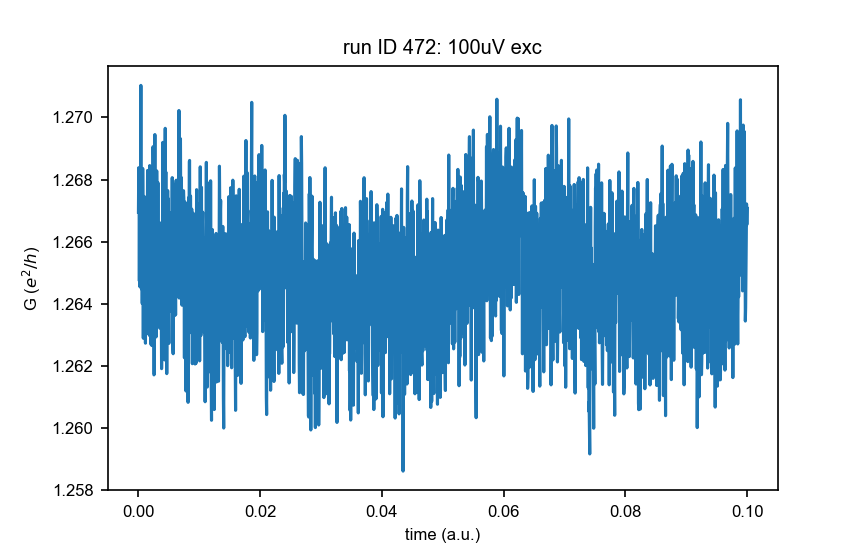

Text(0,0.5,'G ($e^2/h$)')

In [400]:
gate_values = np.array(dat1.get_values('yoko2_voltage'))
current_values = np.array(dat1.get_values('Lockin1_X'))
res = (1e-4/(current_values/1e6) - 15e3)/12906
plt.figure()
plt.plot(gate_values, 1/res)
plt.title('run ID ' + '{}'.format(dat1.run_id) + ': 100uV exc')
plt.xlabel('time (a.u.)')
plt.ylabel('G ($e^2/h$)')

<IPython.core.display.Javascript object>


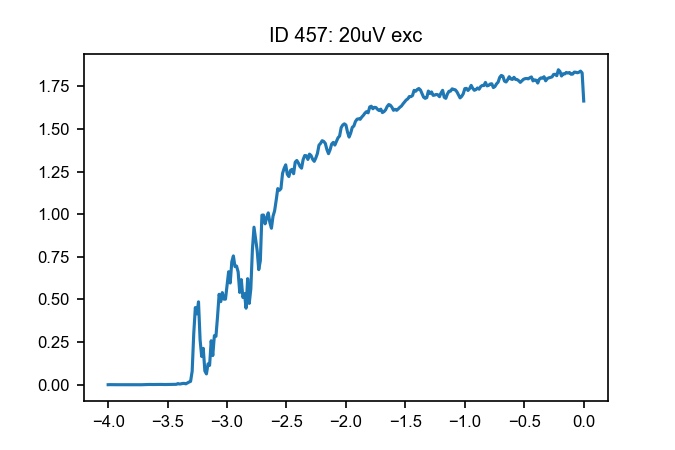

Text(0.5,1,'ID 457: 20uV exc')

In [185]:
gate_values = np.array(dat1.get_values('mdac_gate_voltage'))
current_values = np.array(dat1.get_values('Lockin1_R'))
res = (2e-5/(current_values/1e6) - 15e3)/12906
plt.figure()
plt.plot(gate_values, 1/res)
plt.title('ID 457: 20uV exc')

## Up and down sweeps in one run

In [576]:
# splitting up and down sweeps
gate_values = np.array(dat1.get_values('mdac_gate_voltage'))
current_values = np.array(dat1.get_values('conductance'))
npoints = int(gate_values.size/2)
gate_down = gate_values[0:npoints]
current_down = current_values[0:npoints]
gate_up = gate_values[npoints:-1]
current_up = current_values[npoints:-1]
#plt.figure('testwater')
#plt.plot(gate_up, current_up, gate_down, current_down)

### gate leakage

<IPython.core.display.Javascript object>


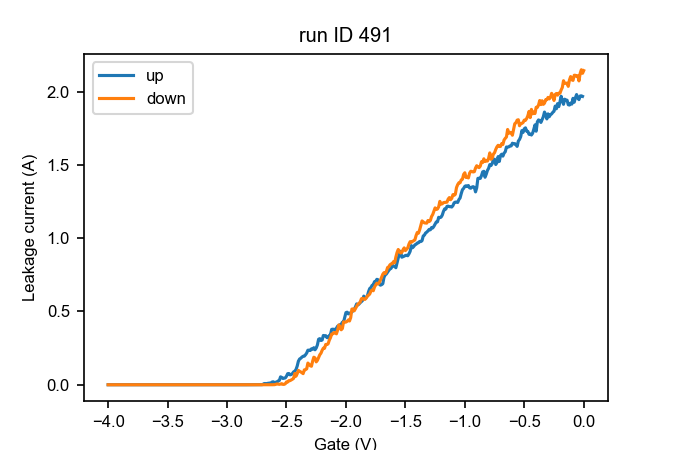

In [577]:
#conductance_up = current_up/(V_bias - current_up*R_s)
#conductance_down = current_down/(V_bias - current_down*R_s)

plt.figure('Leakage current')
plt.plot(gate_up, current_up, gate_down, current_down)
plt.title('run ID ' + '{}'.format(dat1.run_id))
plt.xlabel('Gate (V)')
plt.ylabel('Leakage current (A)')
plt.legend(['up', 'down'])

In [580]:
np.append(np.linspace(4, 0, 8), np.linspace(0, 4, 8))

array([4.        , 3.42857143, 2.85714286, 2.28571429, 1.71428571,
       1.14285714, 0.57142857, 0.        , 0.        , 0.57142857,
       1.14285714, 1.71428571, 2.28571429, 2.85714286, 3.42857143,
       4.        ])

## Pinchoff with $R_\text{series}$ correction

To do: add mobility fitting

<IPython.core.display.Javascript object>


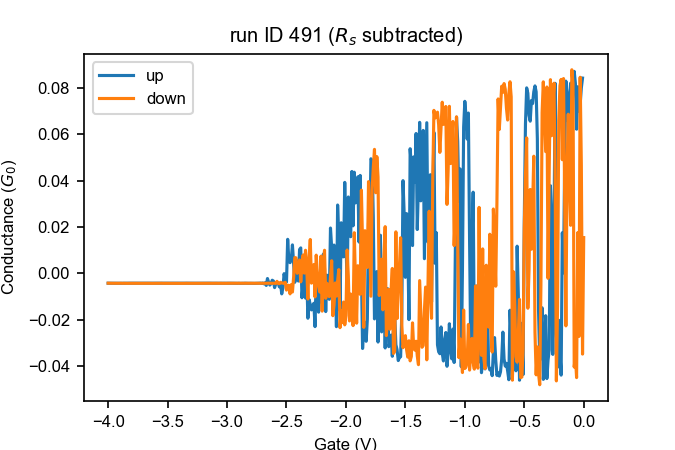

In [575]:
conductance_up = current_up/(V_bias - current_up*R_s)
conductance_down = current_down/(V_bias - current_down*R_s)
plt.figure('conductance minus R_s')
plt.plot(gate_up, conductance_up*12906, gate_down, conductance_down*12906)
plt.title('run ID ' + '{}'.format(dat1.run_id) + ' ($R_s$ subtracted)')
plt.xlabel('Gate (V)')
plt.ylabel('Conductance ($G_0$)')
plt.legend(['up', 'down'])

### 1/f noise

In [248]:
dat1 = load_by_id(455)
R_s = 15e3 # series R in Ohm
V_bias = 2e-3/0.79 #bias voltage in V
dat1.get_parameters()

[yoko2_voltage (numeric),
 current (numeric),
 raw_voltage_dc (numeric),
 conductance (numeric),
 Lockin1_X (numeric),
 Lockin1_Y (numeric),
 Lockin1_R (numeric),
 Lockin1_phase (numeric),
 Lockin1_excitation (numeric)]

<IPython.core.display.Javascript object>


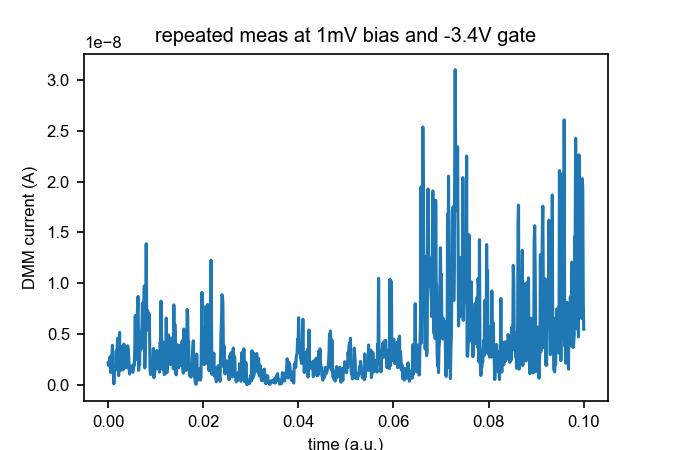

Text(0.5,1,'repeated meas at 1mV bias and -3.4V gate')

In [252]:
gate_values = np.array(dat1.get_values('yoko2_voltage'))[:,0]
current_values = np.array(dat1.get_values('current'))[:,0]
npoints = int(gate_values.size)
plt.figure('noise vs time')
plt.plot(gate_values, current_values)
plt.xlabel('time (a.u.)')
plt.ylabel('DMM current (A)')
plt.title('repeated meas at 1mV bias and -3.4V gate')

<IPython.core.display.Javascript object>


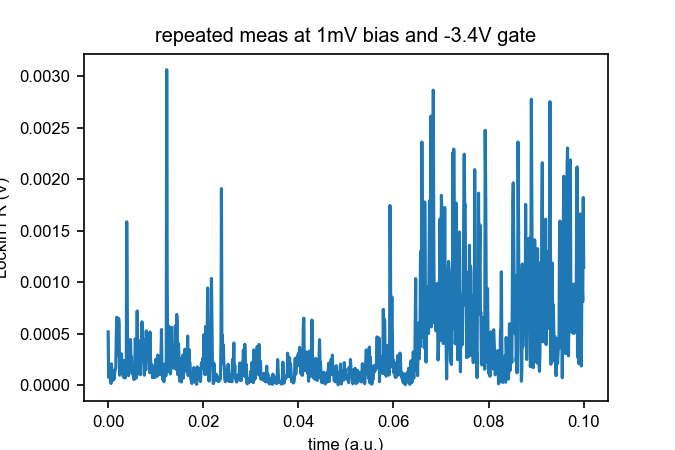

Text(0.5,1,'repeated meas at 1mV bias and -3.4V gate')

In [254]:
conductance_values = np.array(dat1.get_values('Lockin1_R'))[:,0]
plt.figure('noise vs time lockin')
plt.plot(gate_values, conductance_values)
plt.xlabel('time (a.u.)')
plt.ylabel('Lockin1 R (V)')
plt.title('repeated meas at 1mV bias and -3.4V gate')

<IPython.core.display.Javascript object>


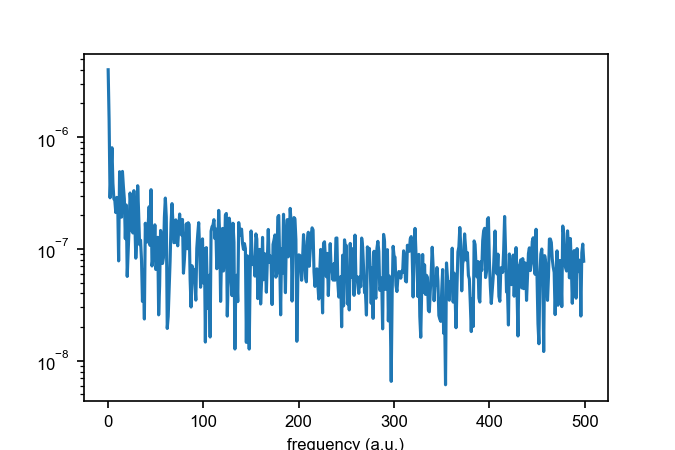

Text(0.5,0,'frequency (a.u.)')

In [263]:
#fft_current = smooth(np.fft.fft(current_values),11,3)
fft_current = np.fft.fft(current_values)
plt.figure('fft of noise vs time')
plt.semilogy(np.abs(fft_current)[:500])
plt.xlabel('frequency (a.u.)')

## 2D plots

In [301]:
dat2D = load_by_id(463)
R_s = 15e3 # series R in Ohm
V_bias = 1e-3 #bias voltage in V
dat2D.get_parameters()

[mdac_bias_voltage (numeric),
 mdac_gate_voltage (numeric),
 current (numeric),
 raw_voltage_dc (numeric),
 conductance (numeric),
 Lockin1_X (numeric),
 Lockin1_Y (numeric),
 Lockin1_R (numeric),
 Lockin1_phase (numeric),
 Lockin1_excitation (numeric)]

In [274]:
inner_loop_values = np.unique(dat2D.get_values('mdac_bias_voltage'))
outer_loop_values = np.unique(dat2D.get_values('mdac_gate_voltage'))
current_values = np.array(dat2D.get_values('current'))[:,0].reshape((inner_loop_values.size, outer_loop_values.size))
current_values.shape


(201, 201)

In [ ]:
plt.figure('test 2D')
plt.pcolor()

In [341]:
def colorplot(data, fast_s, slow_s, z, AC='True'):
    fig=plt.figure()
    #plt.title(data['filepath'])
    #data = data[0]
    fs = np.unique(data.get_values(fast_s))
    ss = np.unique(data.get_values(slow_s))
    print(len(ss))
    z1 = np.array(data.get_values(z))
    r_line = 15e3
    #AC_bias = 20e-6
    #z1 = AC_bias/z1
    #z1 = DC_bias/z1
    #z1 = (1/(z1 - r_line))/G0
    cmap = plt.cm.viridis #seismic, viridis, magma
    norm = mpl.colors.Normalize(vmin=min(z1), vmax=max(z1))
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.ax.set_ylabel('current (A)')
    plt.pcolor(np.unique(fs)[::-1], np.unique(ss)[::-1], np.reshape(z1,(len(np.unique(ss)),len(np.unique(fs)))), cmap=cmap, norm=norm)
    plt.xlabel(fast_s + ' (V)')
    plt.ylabel(slow_s + ' (mV)')

<IPython.core.display.Javascript object>


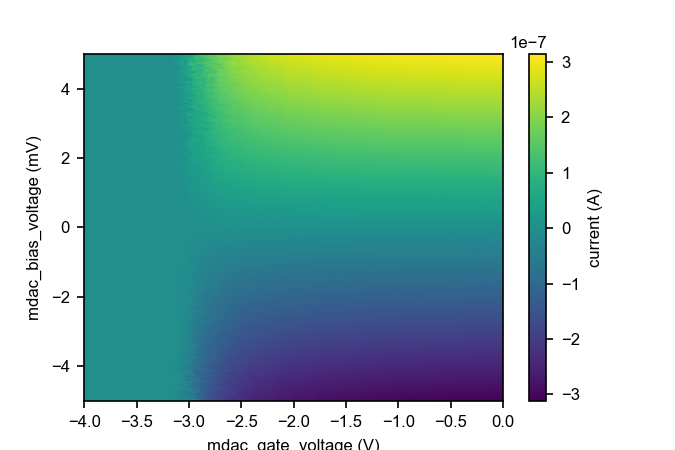

201


In [342]:
colorplot(dat2D, 'mdac_gate_voltage', 'mdac_bias_voltage', 'current')

### 1D from 2D plot

In [33]:
def plot1D_from_2D(data, x, y, x2, x2_value):
    b = np.unique(np.array(data.get_values(x))) #[::-1]
    v2 = np.array(data.get_values(x2))
    points = v2 == x2_value #np.abs((v2 - x2_value)/x2_value) < 1e-6 #v2 == x2_value   # np.abs((v2 - x2_value)/x2_value) < 1e-6
    g = np.array(data.get_values(y))
    g = g[points]
    #g = smooth(g, 21, 3)
    #g_sub = curr2cond(g, 20e-6, 15e3)
    plt.plot(b, g, label=x2+' = '+str(x2_value*10)+'mV')
    plt.xlabel(x+' (V)')
    plt.ylabel('dI/dV (G0)')
    plt.legend()
    #return b #, g_sub

<IPython.core.display.Javascript object>


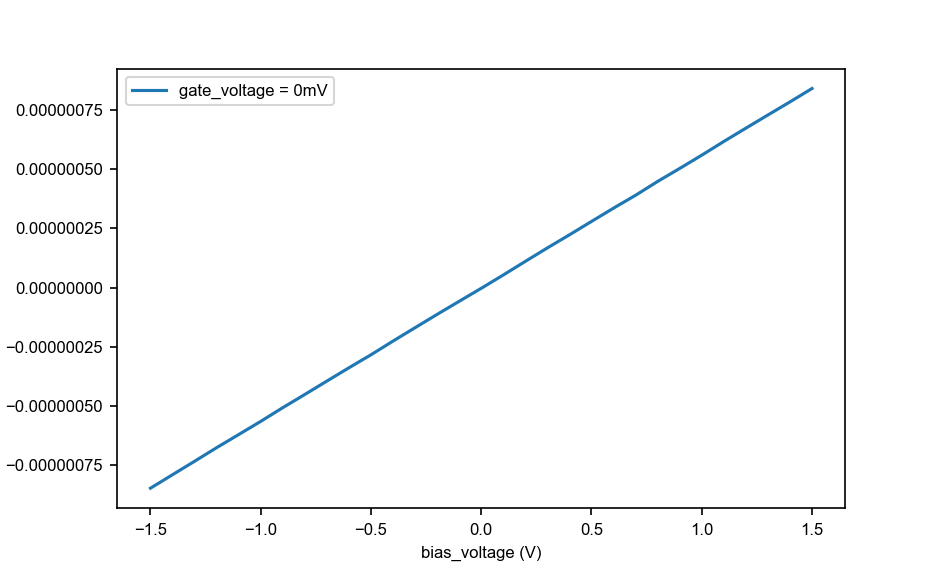

In [34]:
plt.figure()
plot1D_from_2D(dat1, 'bias_voltage', 'I', 'gate_voltage', 0)

In [35]:
10e-3/5e-7

20000.0

In [17]:
plot1D_from_2D(dat1, 'gate_voltage', 'dI', 'bias_voltage', 0.1)

### View gate or bias setpoints

In [22]:
np.unique(dat1.get_values('gate_voltage'))

array([-3.5       , -3.37931034, -3.25862069, -3.13793103, -3.01724138,
       -2.89655172, -2.77586207, -2.65517241, -2.53448276, -2.4137931 ,
       -2.29310345, -2.17241379, -2.05172414, -1.93103448, -1.81034483,
       -1.68965517, -1.56896552, -1.44827586, -1.32758621, -1.20689655,
       -1.0862069 , -0.96551724, -0.84482759, -0.72413793, -0.60344828,
       -0.48275862, -0.36206897, -0.24137931, -0.12068966,  0.        ])

## AB loops

In [623]:
dat_AB = load_by_id(500)
R_s = 10e3 # series R in Ohm
V_bias = 1e-3 #bias voltage in V
dat_AB.get_parameters()

[time_sweep (numeric),
 B_x (numeric),
 current (numeric),
 raw_voltage_dc (numeric),
 conductance (numeric),
 Lockin1_X (numeric),
 Lockin1_Y (numeric),
 Lockin1_R (numeric),
 Lockin1_phase (numeric),
 Lockin1_excitation (numeric)]

<IPython.core.display.Javascript object>


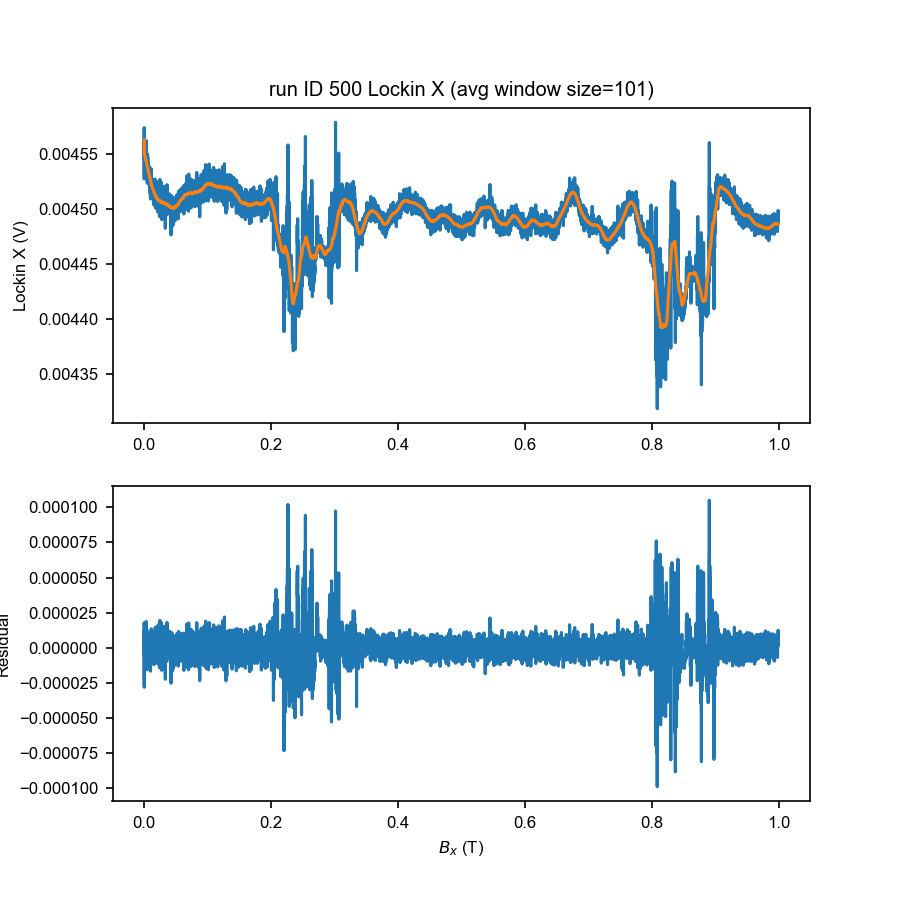

Text(0.5,0,'$B_x$ (T)')

In [624]:
B_values = np.array(dat_AB.get_values('B_x'))[:,0]
B_min, B_max = min(B_values), max(B_values)
npoints = B_values.size
conductance_values = np.array(dat_AB.get_values('Lockin1_X'))[:,0]

avg_window_size = 101
conductance_background = smooth(conductance_values, avg_window_size, 1) # 31 points ~ 15mT, close to expected period
conductance_residual = conductance_values - conductance_background

plt.figure('fft background', figsize=(6,6))
plt.subplot(211)
plt.plot(B_values, conductance_values, B_values, conductance_background)
plt.title('run ID ' + '{}'.format(dat_AB.run_id) + ' Lockin X (avg window size=' + str(avg_window_size) + ')')
plt.ylabel('Lockin X (V)')
plt.subplot(212)
plt.plot(B_values, conductance_residual)
plt.ylabel('Residual')
plt.xlabel('$B_x$ (T)')

<IPython.core.display.Javascript object>


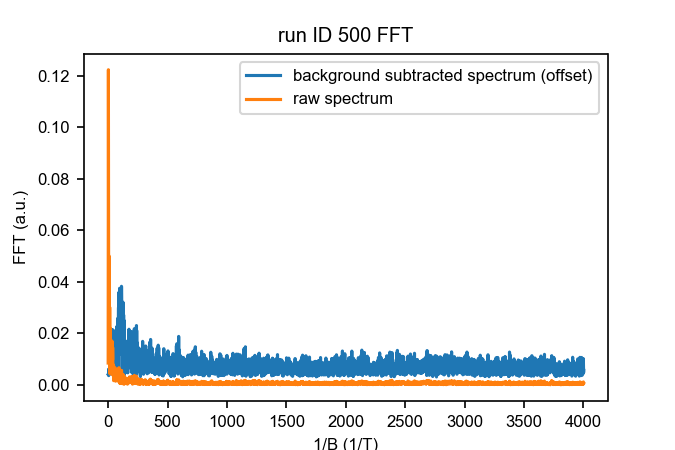

In [625]:
# FFT

fft_ab = np.fft.fft(conductance_residual)
fft_non_avgd = smooth(np.fft.fft(conductance_values - conductance_values.mean()), 7,5)
B_inv = np.linspace(0, npoints/(B_max-B_min), npoints)

plt.figure('abfft')
plt.plot(B_inv[:4000], 5*np.abs(fft_ab)[:4000]+0.003, B_inv[:4000], np.abs(fft_non_avgd)[:4000])
plt.xlabel('1/B (1/T)')
plt.ylabel('FFT (a.u.)')
plt.title('run ID ' + '{}'.format(dat_AB.run_id) + ' FFT')
plt.legend(['background subtracted spectrum (offset)', 'raw spectrum'])

### Averaging FFTs

<IPython.core.display.Javascript object>


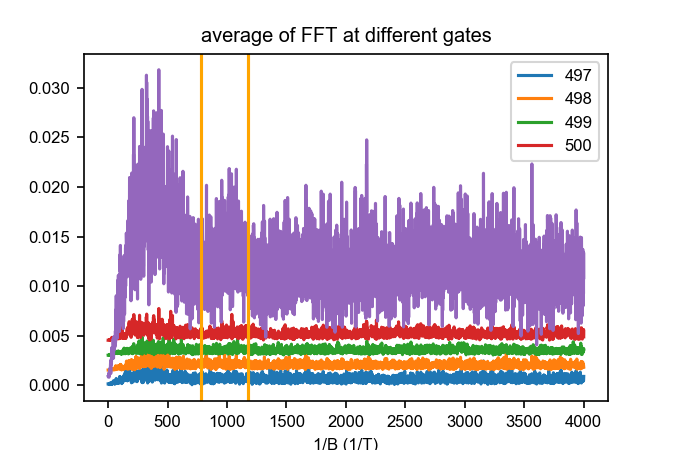

Text(0.5,0,'1/B (1/T)')

In [629]:
data_id_list = [497,498,499,500]
number_points_list = [11000,9999,9999,9000]

B_inv_unified = np.linspace(0,4000,4000)
fft_avg = np.zeros(B_inv_unified.shape)

plt.figure('all AB raw')

counter = 0
for data_id in data_id_list:
    dat_AB = load_by_id(data_id)
    B_values = np.array(dat_AB.get_values('B_x'))[:number_points_list[counter],0]
    B_min, B_max = min(B_values), max(B_values)
    npoints = B_values.size
    conductance_values = np.array(dat_AB.get_values('Lockin1_X'))[:number_points_list[counter],0]

    avg_window_size = 31
    conductance_background = smooth(conductance_values, avg_window_size, 1) # 31 points ~ 15mT, close to expected period
    conductance_residual = conductance_values - conductance_background
    
    fft_ab = np.abs(np.fft.fft(conductance_residual))
    B_inv = np.linspace(0, npoints/(B_max-B_min), npoints)
    
    B_inv_unified
    fft_ab_intp = np.interp(B_inv_unified, B_inv, fft_ab)
    fft_avg += fft_ab_intp
    
    plt.plot(B_inv_unified, fft_ab_intp + 0.0015*counter)
    counter += 1

plt.legend(list(map(str, data_id_list)))
#fft_avg /= counter
plt.plot(B_inv_unified, fft_avg*5)
plt.axvline(x=781, color='orange')
plt.axvline(x=1176, color='orange')
plt.title('average of FFT at different gates')
plt.xlabel('1/B (1/T)')

In [627]:
1000/0.85, 1000/1.28

(1176.4705882352941, 781.25)